# Software Setup, Dependencies

In [39]:
%pip install -r requirements.txt > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [82]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib as mp
import matplotlib.pyplot as plt
import importlib
from scipy.optimize import curve_fit


import salduba.simulation.ggk as ggk
importlib.reload(ggk)
from salduba.simulation.ggk import exponential, parametrized_gamma


# Set up Configuration parameters

In [41]:
inter_arrival_time = 1.0
op_time = inter_arrival_time/1000
target_utilization = 0.9
k_servers: int = 10
processing_time = inter_arrival_time * k_servers * target_utilization
gamma_shape = 9.0

n_jobs: int = 50000
sampling_target: float = 5.0
simulation_factor: float = 100.0

sampling_period = int(inter_arrival_time * sampling_target)
time_limit = int(inter_arrival_time * n_jobs + target_utilization/(1-target_utilization)*inter_arrival_time*simulation_factor)
jobs_limit: int = round(time_limit/inter_arrival_time)

time_unit: float = sampling_period*10

arrival_distribution: ggk.Distribution = exponential(inter_arrival_time, time_unit)
processing_distribution: ggk.Distribution = parametrized_gamma(gamma_shape, processing_time, time_unit)
success_distribution = ggk.coin_toss(0.95)

# Metrics Calculation Parameters

n_metrics_intervals = 200
warm_up_fraction = 0.1

# Simulation Values

## Arrival Times & Jobs Data Frame

*jobs := [arrival time, processing time, start, complete, arrived, pending]*

- **Id** A unique Id for the job, corresponding to its arrival order
- **Arrival Time**: When the job arrives to the system
- **Processing Time**: The time the system takes to process the job once started
- **Start**: The time when the system starts processing the job.
- **Complete**: The time when the system completes processing of the job. It is always the case that $Complete = ArrivalTime + ProcessingTime$
- **Arrived**: How many jobs have arrived up until the time of this arrival, including this one.
- **Pending**: How many jobs are in the system or "pending" at the time of arrival.
- **WIP**: How many jobs are currently being actively worked on.
- **DONE**: How many jobs are currently Complete.

In [42]:
jobs: pd.DataFrame = ggk.initialize_jobs(n_jobs, arrival_distribution, processing_distribution, success_distribution)

jobs

,Id,Arrival,InterArrival,ProcessingTime,Start,Complete,Success,Arrived,Pending,WIP,DONE,QueuingFactor,WaitTime,LeadTime
0,0,0,21,266,-1,-1,1,1,-1,-1,-1,-1,-1,-1
1,1,21,1,594,-1,-1,1,2,-1,-1,-1,-1,-1,-1
2,2,22,178,492,-1,-1,0,3,-1,-1,-1,-1,-1,-1
3,3,200,6,487,-1,-1,1,4,-1,-1,-1,-1,-1,-1
4,4,206,23,257,-1,-1,1,5,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49996,2514781,29,326,-1,-1,1,49997,-1,-1,-1,-1,-1,-1
49997,49997,2514810,2,799,-1,-1,1,49998,-1,-1,-1,-1,-1,-1
49998,49998,2514812,21,425,-1,-1,1,49999,-1,-1,-1,-1,-1,-1
49999,49999,2514833,235,592,-1,-1,0,50000,-1,-1,-1,-1,-1,-1


In [43]:
history_starts, history_ends, samples = ggk.fill_in_dynamic_values(jobs, k_servers, warm_up_fraction)

(history_starts, history_ends)

(255898, 2515764)

In [44]:
samples

,Id,Arrival,InterArrival,ProcessingTime,Start,Complete,Success,Arrived,Pending,WIP,DONE,QueuingFactor,WaitTime,LeadTime
5001,5001,255898,34,469,256022,256491,1,5002,11,10,4990,0.264392,124,593
5002,5002,255932,145,348,256053,256401,1,5003,12,10,4990,0.347701,121,469
5003,5003,256077,95,423,256089,256512,1,5004,10,10,4993,0.028369,12,435
5004,5004,256172,4,336,256188,256524,1,5005,10,10,4994,0.047619,16,352
5005,5005,256176,5,585,256190,256775,1,5006,11,10,4994,0.023932,14,599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49996,2514781,29,326,2514899,2515225,1,49997,11,10,49985,0.361963,118,444
49997,49997,2514810,2,799,2514924,2515723,1,49998,12,10,49985,0.142678,114,913
49998,49998,2514812,21,425,2514945,2515370,1,49999,13,10,49985,0.312941,133,558
49999,49999,2514833,235,592,2514969,2515561,0,50000,14,10,49985,0.229730,136,728


# Exploration of Simulation

## WIP Avg stabilization

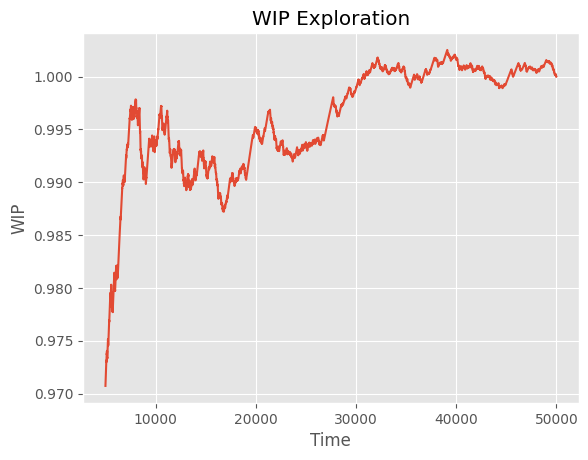

8.945681086378272

In [45]:
start_job = 5000
jobs_to_plot = 50000

mean_wip = jobs['WIP'].mean()
ratio = [jobs['WIP'][0:idx].mean()/mean_wip for idx in range(start_job, jobs_to_plot)]

plt.figure()
plt.plot(job_idx, ratio)
plt.xlabel('Time')
plt.ylabel('WIP')
plt.title('WIP Exploration')
plt.show()

mean_wip

# Metrics Parameters

## Determine valid samples from the simulation

- Allow to warm up
- Eliminate arrivals that don't complete

In [46]:
total_duration = history_ends - history_starts
metric_interval = round((history_ends - history_starts)/n_metrics_intervals)
ticks = np.arange(history_starts, history_ends, metric_interval)

In [47]:
samples

,Id,Arrival,InterArrival,ProcessingTime,Start,Complete,Success,Arrived,Pending,WIP,DONE,QueuingFactor,WaitTime,LeadTime
5001,5001,255898,34,469,256022,256491,1,5002,11,10,4990,0.264392,124,593
5002,5002,255932,145,348,256053,256401,1,5003,12,10,4990,0.347701,121,469
5003,5003,256077,95,423,256089,256512,1,5004,10,10,4993,0.028369,12,435
5004,5004,256172,4,336,256188,256524,1,5005,10,10,4994,0.047619,16,352
5005,5005,256176,5,585,256190,256775,1,5006,11,10,4994,0.023932,14,599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49996,49996,2514781,29,326,2514899,2515225,1,49997,11,10,49985,0.361963,118,444
49997,49997,2514810,2,799,2514924,2515723,1,49998,12,10,49985,0.142678,114,913
49998,49998,2514812,21,425,2514945,2515370,1,49999,13,10,49985,0.312941,133,558
49999,49999,2514833,235,592,2514969,2515561,0,50000,14,10,49985,0.229730,136,728


In [48]:
samples['QueuingFactor'].min()

0.0008130081300813008

In [49]:
# Make the calculation period a bit longer than the metric period, just for testing (Trailing average longer than metric period)
calculation_period = round(metric_interval*1.2)
  
calculation_intervals = [pd.Interval(tick-calculation_period, tick, closed='left') for tick in ticks]
calculation_groups = [[itv.left, itv.right, samples[samples['Complete'].between(itv.left, itv.right, inclusive='left')]] for itv in calculation_intervals]

metrics = pd.DataFrame(
  columns=['Yield', 'Throughput', 'ProcessingTime', 'Utilization', 'WaitTime', 'LeadTime', 'WIP', 'QueuingFactor'],
  index=[g[1] for g in calculation_groups],
  data=[
    (
     g[2]['Success'].mean() if len(g[2]) > 0 else 0,
     g[2].index.size/calculation_period,
     g[2]['ProcessingTime'].mean() if g[2].index.size > 0 else 0,
     -1,
     g[2]['WaitTime'].mean() if g[2].index.size > 0 else 0,
     g[2]['LeadTime'].mean() if g[2].index.size > 0 else 0,
     (g[2]['InterArrival']*g[2]['WIP']).sum()/g[2]['InterArrival'].sum() if g[2].index.size > 0 else 0,
     g[2]['QueuingFactor'].mean() if g[2].index.size > 0 else 0
   ) for g in calculation_groups]
  )[1:]
metrics['Utilization'] = metrics['Throughput']*metrics['ProcessingTime']/k_servers
metrics

,Yield,Throughput,ProcessingTime,Utilization,WaitTime,LeadTime,WIP,QueuingFactor
267197,0.964602,0.016668,447.504425,0.745896,143.225664,590.730088,9.483819,0.371588
278496,0.945017,0.021462,456.975945,0.980751,284.388316,741.364261,9.655546,0.699891
289795,0.954717,0.019544,455.150943,0.889557,161.815094,616.966038,9.073632,0.378331
301094,0.943060,0.020724,435.761566,0.903083,155.249110,591.010676,9.093508,0.415182
312393,0.960159,0.018512,475.027888,0.879357,151.557769,626.585657,8.819450,0.347723
...,...,...,...,...,...,...,...,...
2470502,0.959854,0.020208,446.222628,0.901726,123.437956,569.660584,9.155473,0.305675
2481801,0.924812,0.019618,446.781955,0.876495,58.601504,505.383459,8.739477,0.149492
2493100,0.936255,0.018512,451.410359,0.835637,66.868526,518.278884,8.379981,0.175482
2504399,0.941176,0.017553,438.533613,0.769754,51.399160,489.932773,7.767151,0.137764


## Reporting Periods

Will prepare two *Reports* with each 1/2 of the samples.


In [50]:

mid_point = round((history_starts + history_ends)/2)

reporting_periods = [
  {
    'name': "Period 1",
    'start_time': history_starts,
    'end_time' : mid_point,
    'jobs': samples[samples['Complete'] <= mid_point],
    'metrics': metrics.loc[history_starts:mid_point]
  },
  {
    'name': "Period 2",
    'start_time': mid_point+1,
    'end_time': history_ends,
    'jobs': samples[samples['Complete'] > mid_point],
    'metrics': metrics.loc[mid_point:]
  }
]



# Yields

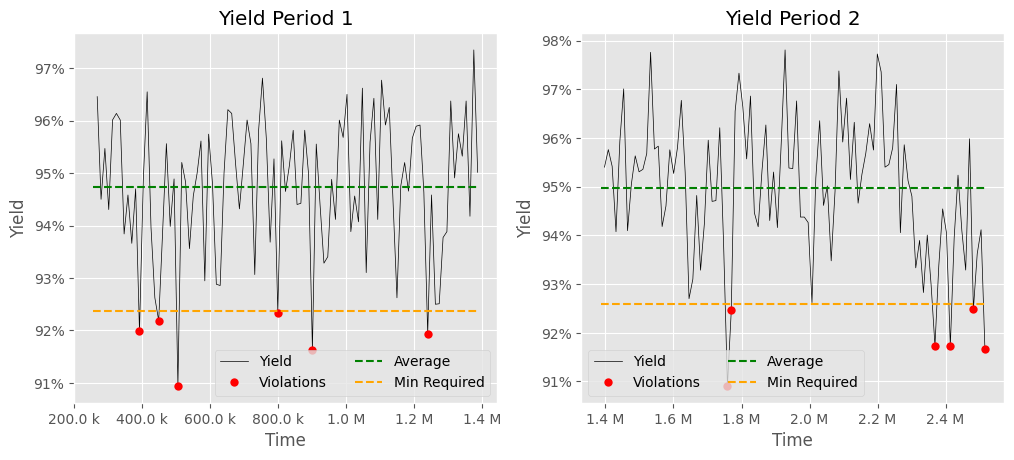

In [51]:
plt.style.use('ggplot')

yield_min_factor = 0.975

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(12)
ax0, ax1 = axes.ravel()

reports = [
  {
    'axe': ax0,
    'period': reporting_periods[0]
  },
  {
    'axe': ax1,
    'period': reporting_periods[1]
  }
]

for r in reports:
  ax = r['axe']
  metrics = r['period']['metrics']
  yield_avg = metrics['Yield'].mean()
  min_required = yield_avg*yield_min_factor
  metrics['Yield'].plot(ax=ax, color='black', linestyle='-', linewidth=0.5)
  metrics[metrics['Yield'] < min_required]['Yield'].plot(ax=ax, color='black', linestyle='', marker='o', markeredgewidth=0.0, markerfacecolor='red', label='Violations')
  ax.xaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.yaxis.set_major_formatter(mp.ticker.PercentFormatter(xmax=1.0, decimals=0))
  ax.plot([r['period']['start_time'], r['period']['end_time']], [yield_avg, yield_avg], label="Average", color="green", linestyle='--')
  ax.plot([r['period']['start_time'], r['period']['end_time']], [min_required, min_required], label="Min Required", color='orange', linestyle='--')
  ax.set_xlabel('Time')
  ax.set_ylabel('Yield')
  ax.set_title(f"Yield {r['period']['name']}")
  ax.legend(ncols=2)
  

plt.show()



# Throughput

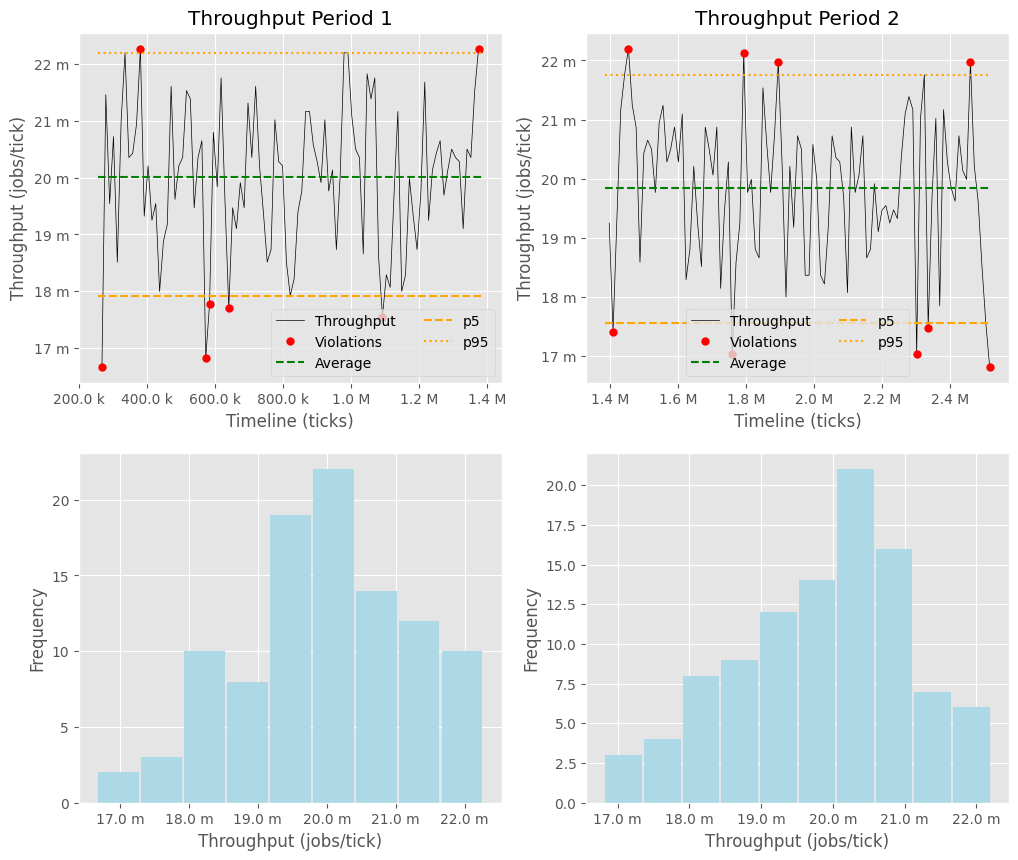

In [83]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'Throughput'

ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail, 'jobs/tick', False)

# Utilization

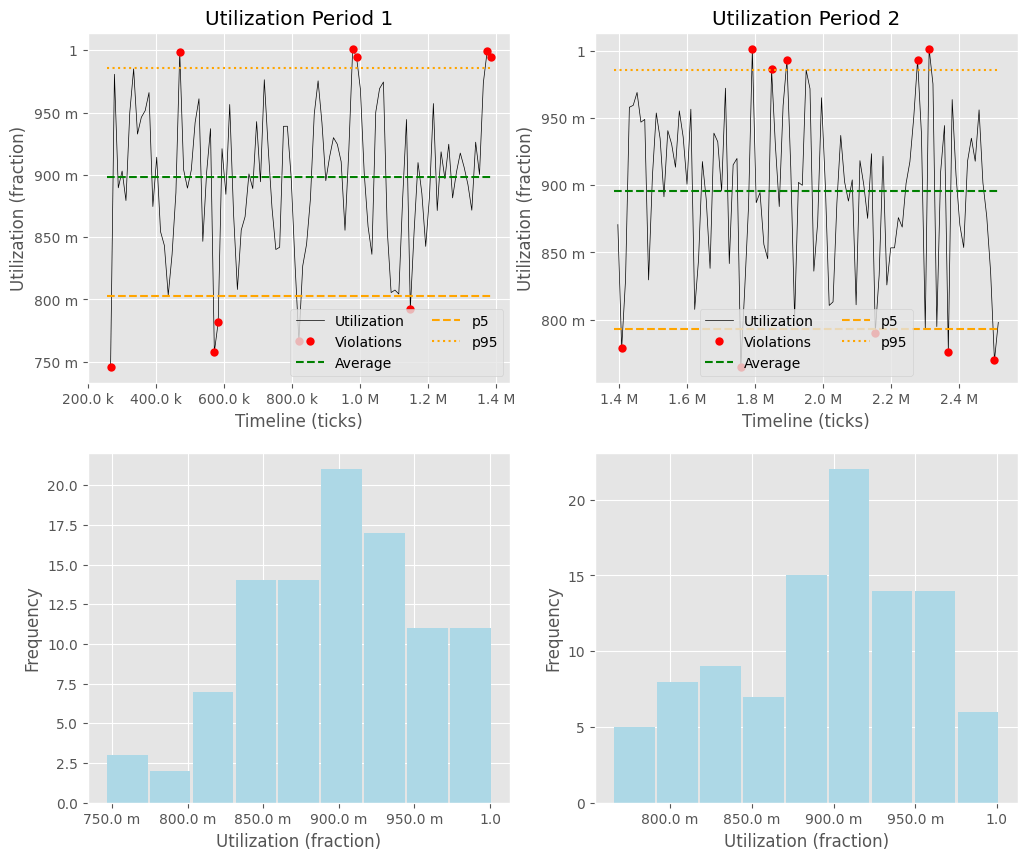

In [84]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'Utilization'

ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail, 'fraction', False)

# Dwell Times

## Wait Time

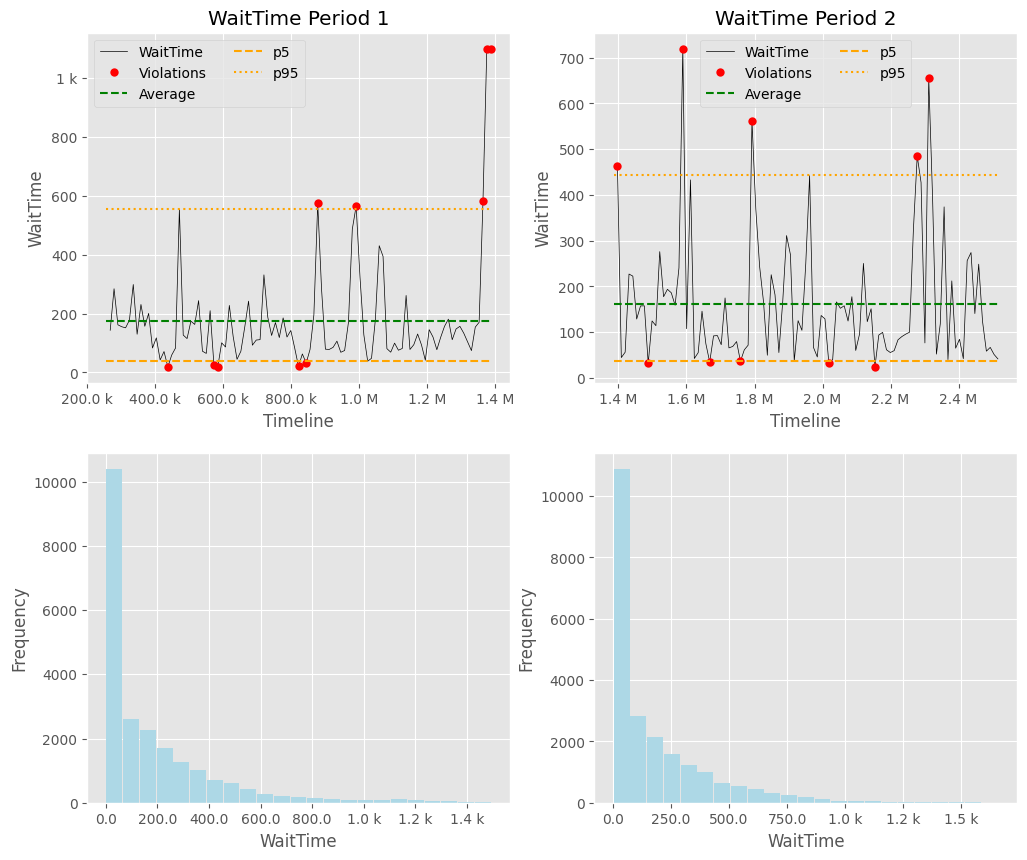

In [54]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'WaitTime'

ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail)

## Processing Time

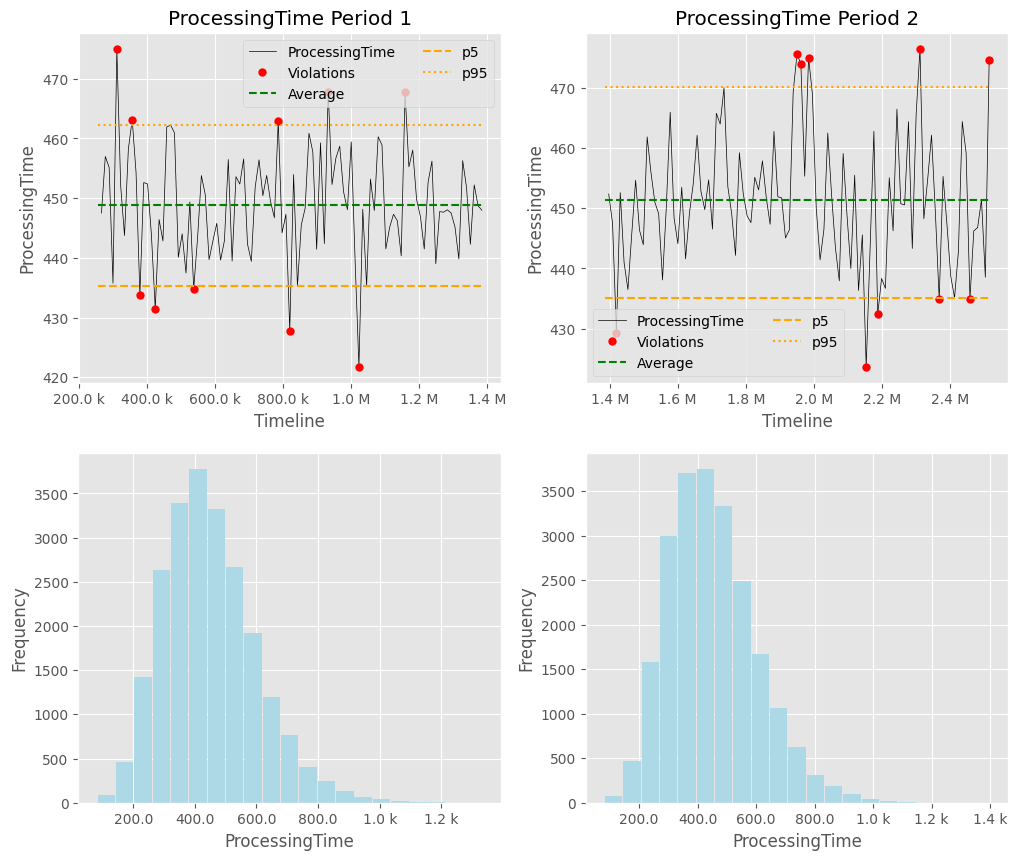

In [55]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'ProcessingTime'


ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail)


## Lead Time

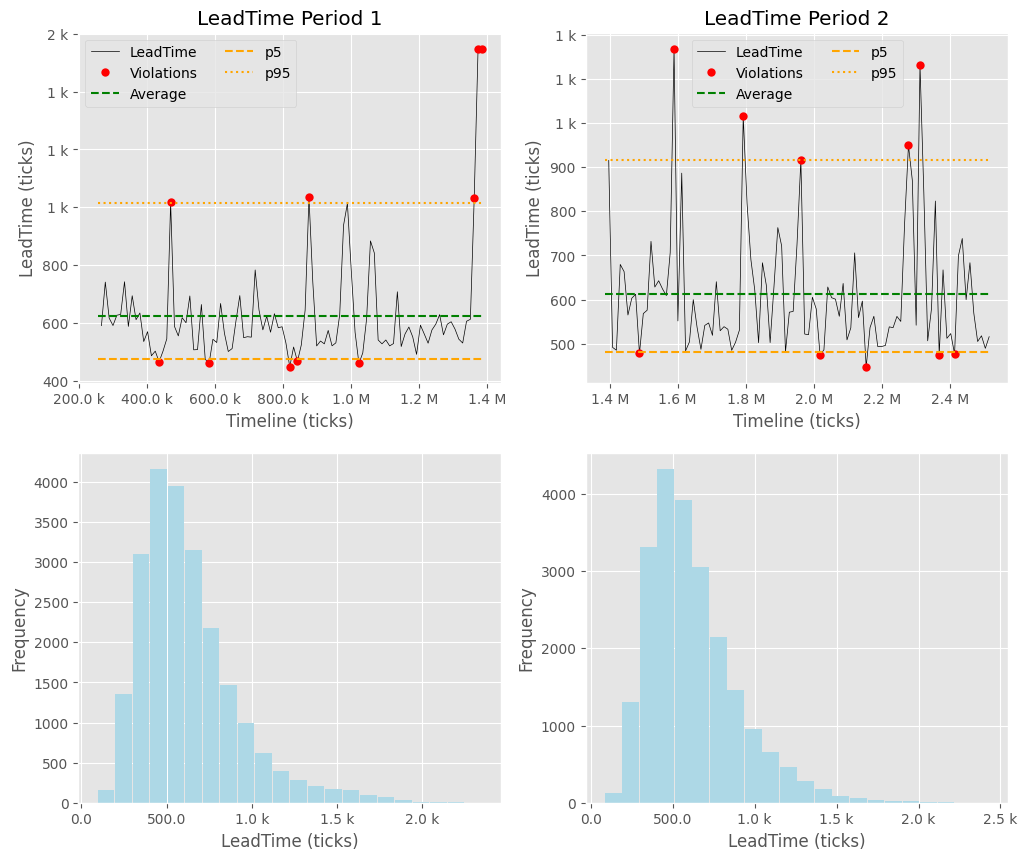

In [85]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'LeadTime'
ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail, 'ticks')


## Queuing Factor

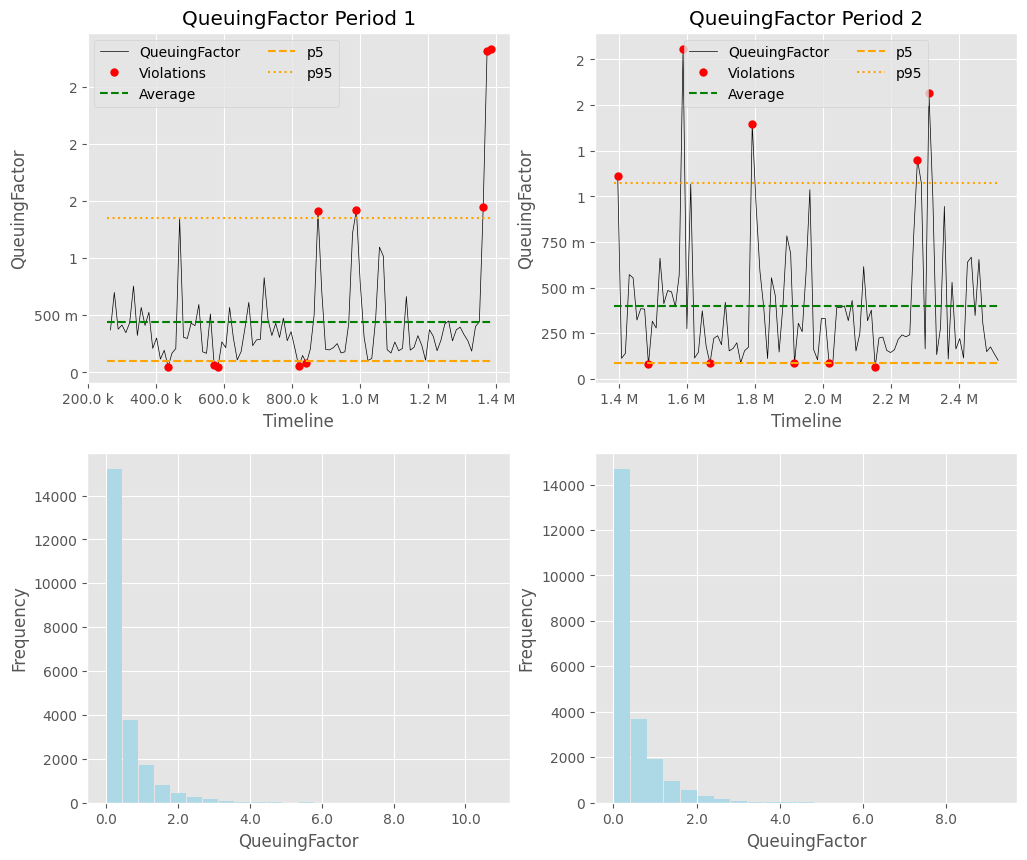

In [57]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'QueuingFactor'
ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail)


# WIP

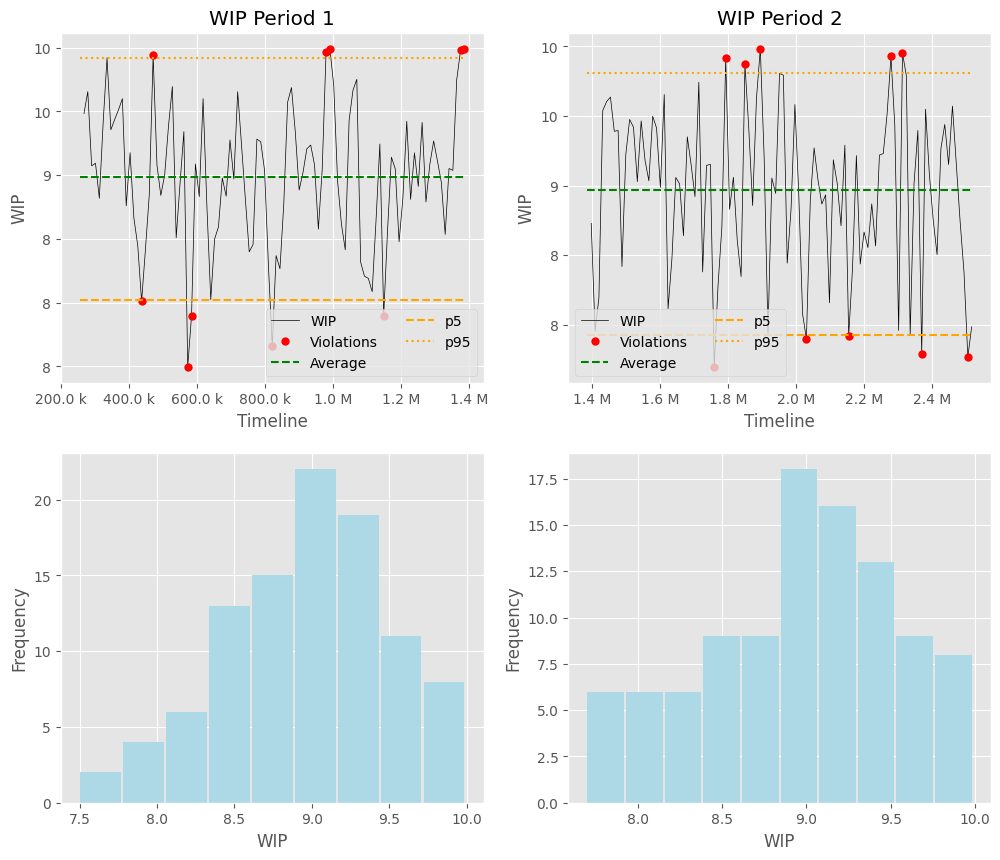

In [58]:
right_tail = 0.05
left_tail = 0.05
report_dimension = 'WIP'
ggk.plot_times(report_dimension, reporting_periods, left_tail, right_tail, False)

# Cross Reports

## Lead Time vs. Throughput

/var/folders/pc/2vy016913bs5kzpn254yq_f40000gn/T/ipykernel_30043/1982047841.py:40: OptimizeWarning: Covariance of the parameters could not be estimated
  param, param_cov = curve_fit(target, ordered[x_series], ordered[y_series] )


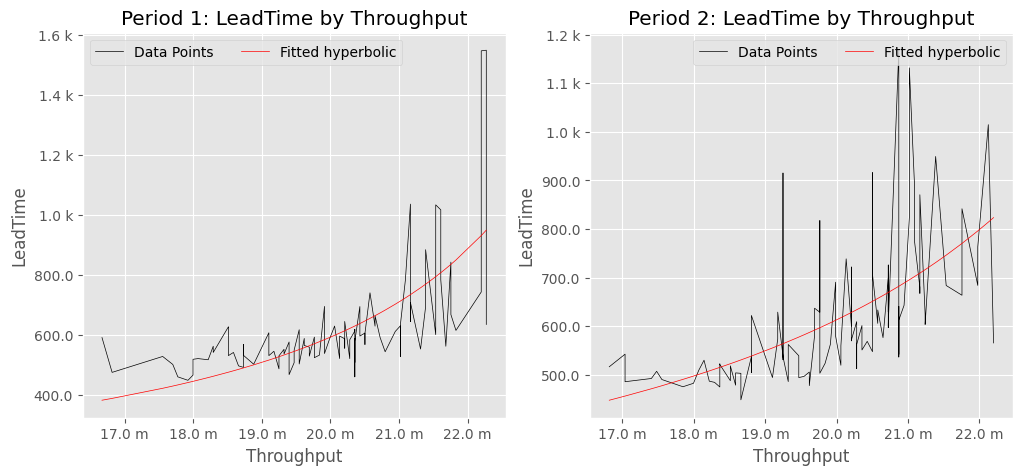

In [59]:
x_series = 'Throughput'
y_series = 'LeadTime'




fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(12)
fig.set_figheight(5)
ax0, ax1 = axes

reports = [
  {
    'axe': ax0,
    'period': reporting_periods[0]
  },
  {
    'axe': ax1,
    'period': reporting_periods[1]
  }
]

def target(th: float, tau: float, th_std: float, tau_std: float) -> float:
  c_s2 = np.power(tau_std/tau, 2.0)
  c_a2 = np.power(th_std*th, 2.0)
  var_squared = (c_s2+c_a2)/2.0
  rho = th*tau
  return var_squared/(1.0-rho)

for r in reports:
  ax = r['axe']
  metrics = r['period']['metrics']
  ax.xaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.yaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.set_xlabel(x_series)
  ax.set_ylabel(y_series)
  ax.set_title(f"{r['period']['name']}: {y_series} by {x_series}")
  ordered = metrics.sort_values(x_series)
  ax.plot(ordered[x_series], ordered[y_series], color='black', linestyle='-', linewidth=0.5, label="Data Points")
  param, param_cov = curve_fit(target, ordered[x_series], ordered[y_series] )
  fitted = ordered[x_series].apply(lambda x : target(x, param[0], param[1], param[2]))
  ax.plot(ordered[x_series], fitted, color='red', linestyle='-', linewidth=0.5, label="Fitted hyperbolic", )
  ax.legend(ncols=2)


## Lead Time vs. Utilization

Parameters: [ 7.96108841e+01 -4.30633965e-04  4.93105060e+00]
Covariances: [[ 1.14229580e+18 -2.48715161e+13  7.07531892e+16]
 [-2.48715161e+13  1.94208677e+09 -1.54052881e+12]
 [ 7.07531892e+16 -1.54052881e+12  4.38241458e+15]]
Parameters: [1.07203427e+00 2.84676283e-06 1.69335336e-01]
Covariances: [[ 1.79492377e+14 -1.43547068e+08  2.83520793e+13]
 [-1.43547068e+08  1.10077243e+04 -2.26742659e+07]
 [ 2.83520793e+13 -2.26742659e+07  4.47840970e+12]]


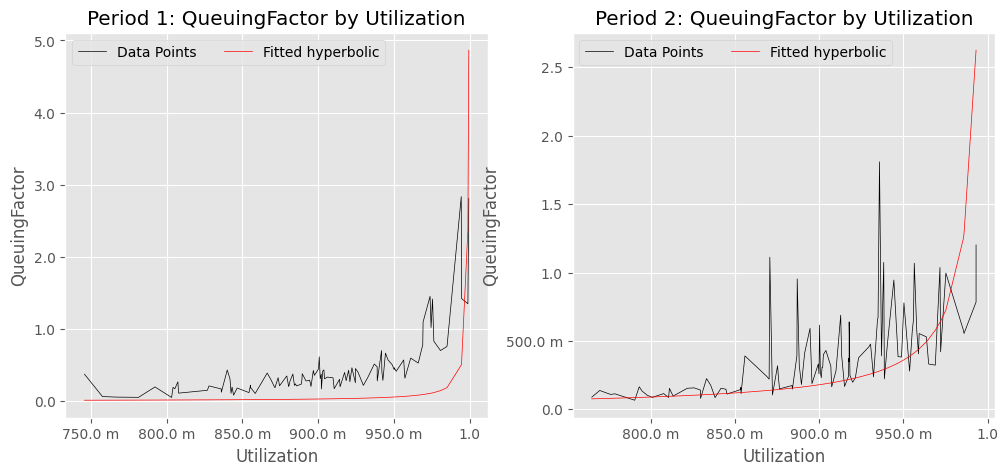

In [76]:
x_series = 'Utilization'
y_series = 'QueuingFactor'



fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(12)
fig.set_figheight(5)
ax0, ax1 = axes

reports = [
  {
    'axe': ax0,
    'period': reporting_periods[0]
  },
  {
    'axe': ax1,
    'period': reporting_periods[1]
  }
]

def target(rho: float, tau: float, th_std: float, tau_std: float) -> float:
  c_s2 = np.power(tau_std/tau, 2.0)
  c_a2 = np.power(rho*th_std/tau, 2.0)
  var_squared = (c_s2+c_a2)/2.0
  return var_squared/(1.0-rho)

variance_factor = 1.2

for r in reports:
  ax = r['axe']
  metrics = r['period']['metrics']
  ax.xaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.yaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.set_xlabel(x_series)
  ax.set_ylabel(y_series)
  ax.set_title(f"{r['period']['name']}: {y_series} by {x_series}")
  ordered = metrics[metrics['Utilization'] < 1.0].sort_values(x_series)
  ax.plot(ordered[x_series], ordered[y_series], color='black', linestyle='-', linewidth=0.5, label="Data Points")
  param, param_cov = curve_fit(target, ordered[x_series], ordered[y_series] )
  print(f"Parameters: {param}")
  print(f"Covariances: {param_cov}")
  fitted = ordered[x_series].apply(lambda x : target(x, param[0], param[1]*variance_factor, param[2]*variance_factor))
  ax.plot(ordered[x_series], fitted, color='red', linestyle='-', linewidth=0.5, label="Fitted hyperbolic", )
  ax.legend(ncols=2)
  


## Lead Time vs WIP

Intercept at: [[-1337.04566538]]
Intercept at: [[-804.4240937]]


/Users/jmp/.pyenv/versions/3.11.6/envs/symbolic-notebooks/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/Users/jmp/.pyenv/versions/3.11.6/envs/symbolic-notebooks/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


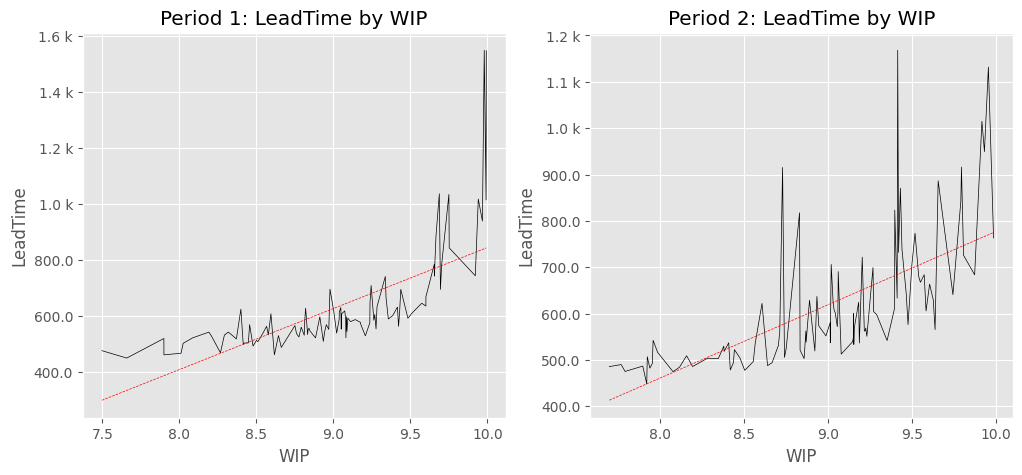

In [75]:
y_series = 'LeadTime'
x_series = 'WIP'

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(12)
fig.set_figheight(5)
ax0, ax1 = axes

reports = [
  {
    'axe': ax0,
    'period': reporting_periods[0]
  },
  {
    'axe': ax1,
    'period': reporting_periods[1]
  }
]

for r in reports:
  ax = r['axe']
  metrics = r['period']['metrics']
  ax.xaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.yaxis.set_major_formatter(mp.ticker.EngFormatter(places=1))
  ax.set_xlabel(x_series)
  ax.set_ylabel(y_series)
  ax.set_title(f"{r['period']['name']}: {y_series} by {x_series}")
  ordered = metrics.sort_values(x_series)
  reg = Ridge(copy_X=True).fit(ordered[[x_series]], ordered[[y_series]])
  trend = reg.predict(ordered[[x_series]])
  ax.plot(ordered[x_series], ordered[y_series], color='black', linestyle='-', linewidth=0.5)
  ax.plot(ordered[x_series], trend, color='red', linestyle='--', linewidth=0.5)
